## Eikonal Ray Equations

In [1]:
# Eikonal ray equation: d(n*dx_i/ds)/ds = dn/dx_i
# s: path length
# n: refractive index
# x_i: cooridinate x, y, z

from sympy import *
n, s, x_i = symbols("n, s, x_i")
 
flux = Derivative(x_i, s) * n
Eq(Derivative(flux, s), Derivative(n, x_i))

Eq(Derivative(n*Derivative(x_i, s), s), Derivative(n, x_i))

In [2]:
# S: wavefront  -- It may be also intepreted as travel time
# n: refractive index -- It may be also interpreted as slowness (1/speed)

S, x, y, z = symbols("S x y z")
Eq(Derivative(S, x)**2+Derivative(S, y)**2+Derivative(S, z)**2, n**2)

Eq(Derivative(S, x)**2 + Derivative(S, y)**2 + Derivative(S, z)**2, n**2)

In [3]:
# t: travel time
# s: slowness (1/speed)

t, s, x, y, z = symbols("t s x y z")
Eq(Derivative(t, x)**2+Derivative(t, y)**2+Derivative(t, z)**2, s**2)

Eq(Derivative(t, x)**2 + Derivative(t, y)**2 + Derivative(t, z)**2, s**2)

## Eikonal equation solver -- ODE

C:\Users\12015\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


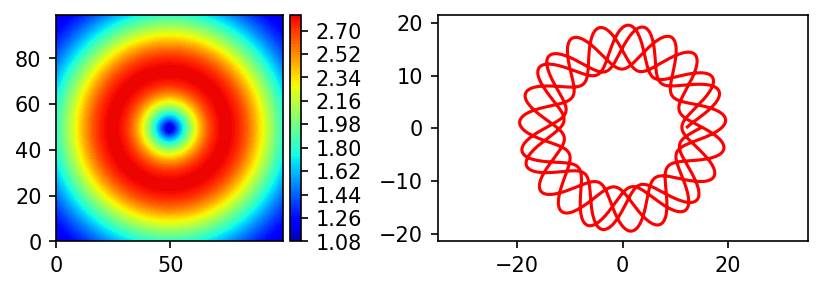

In [4]:
# https://galileo-unbound.blog/2019/05/30/the-iconic-eikonal-and-the-optical-path/
# D. D. Nolte, Introduction to Modern Dynamics: Chaos, Networks, Space and Time, 2nd ed. (Oxford,2019) P336

import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

 
def lens_index(x, y, selection=2):
     
    if selection == 1:
        sig = 10
        n = 1 + np.exp(-(x**2 + y**2)/2/sig**2)
        nx = (-2*x/2/sig**2)*np.exp(-(x**2 + y**2)/2/sig**2)
        ny = (-2*y/2/sig**2)*np.exp(-(x**2 + y**2)/2/sig**2)
         
    elif selection == 2:
        sig = 10;
        r2 = (x**2 + y**2)
        r1 = np.sqrt(r2)
        expon = np.exp(-r2/2/sig**2)
        n = 1+0.3*r1*expon
        nx = 0.3*r1*(-2*x/2/sig**2)*expon + 0.3*expon*2*x/r1
        ny = 0.3*r1*(-2*y/2/sig**2)*expon + 0.3*expon*2*y/r1

    return [n,nx,ny]
 
 
def flow_deriv(y, ts):
    # Eikonal ray equation -- ODE array
    
    n, nx, ny = lens_index(y[0], y[1])
    yp = [y[2]/n, y[3]/n, nx, ny]
    
    return yp
                 
x = np.linspace(-20, 20, 100, endpoint=True)
xx, yy = np.meshgrid(x, x)
n, nx, ny = lens_index(xx, yy) 

fig, axs = plt.subplots(1, 2, figsize=(7, 2), dpi=150)
contr = axs[0].contourf(n, 100, cmap='jet', vmin = 1, vmax = 3)
axs[0].axis('equal')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(contr, cax=cax, orientation='vertical')

## Initial conditions
## [v1, v2] = [n*cos(theta), n*sin(theta)]
v1 = 0.707
v2 = np.sqrt(1-v1**2)
y0 = [12, 0, v1 , v2] 

 
tspan = np.linspace(1, 1700, 1700)
y = integrate.odeint(flow_deriv, y0, tspan)

axs[1].plot(y[1:1550, 0], y[1:1550, 1], 'r')
_ = axs[1].axis('equal')

## Eikonal equation solver -- Finite Difference

<ipython-input-5-541099b966a6>:9: RuntimeWarning: invalid value encountered in sqrt
  n = np.where(((x-x0)**2+(y-y0)**2>=r**2) or x<30, 1, np.sqrt(2-((x-x0)**2+(y-y0)**2)/r**2))


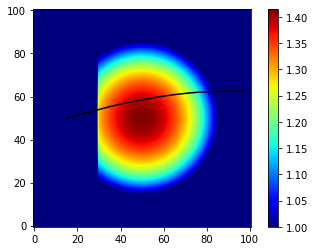

In [5]:
import time, glob, shutil, os
import numpy as np
import matplotlib.pyplot as plt

## Note: Finite difference method still fails to resolve abrupt lens boundary

def system_index(x, y, x0=50, y0=50, n_background = 1, n_lens = 1.5, r=35):
    if not hasattr(x, "__len__"):
        n = np.where(((x-x0)**2+(y-y0)**2>=r**2) or x<30, 1, np.sqrt(2-((x-x0)**2+(y-y0)**2)/r**2))
    else:
        n = np.where((x-x0)**2+(y-y0)**2>=r**2, 1, np.sqrt(2-((x-x0)**2+(y-y0)**2)/r**2))
#         n[x<50] = 1
    return n

z, x = 100, 100
zz, xx = np.meshgrid(np.arange(z+1), np.arange(x+1))  

n = np.zeros_like(zz, dtype='f').flatten()
for idx, (tx, ty) in enumerate(zip(zz.flatten(), xx.flatten())): 
    n[idx] = system_index(tx, ty)
n = n.reshape(zz.shape)
# print(n.max(), n.min(), n[50, 50])
plt.figure()
plt.imshow(n, origin='lower', cmap='jet')
plt.colorbar()

dz= 0.05
theta = np.deg2rad(15)
pz = dz * np.zeros(int(z/dz))
pz[:2] = [15, 15+dz]
px = np.zeros_like(pz)
px[:2] = [50, 50.00+dz*np.tan(theta)]

for k in np.arange(1, int(z/dz)-1):
    
    ep = dz/10
    dndz = (system_index(pz[k]+ep, px[k]) - system_index(pz[k], px[k]))/ep
    dndx = (system_index(pz[k], px[k]+ep) - system_index(pz[k], px[k]))/ep
    n1 = system_index(pz[k], px[k])
    n2 = system_index(pz[k-1], px[k-1])
    dx = px[k] - px[k-1]
    dz = pz[k] - pz[k-1]
#     print(k, n1, n2, pz[k], px[k])

    px[k+1] = px[k] + (n2 * (px[k]-px[k-1])+ dndx * (dx**2 + dz**2))/n1
    pz[k+1] = pz[k] + (n2 * (pz[k]-pz[k-1])+ dndz * (dx**2 + dz**2))/n1

# plt.figure()
plt.plot(pz, px, 'k-')

## Eikonal equation solver -- Finite Difference

<ipython-input-5-541099b966a6>:9: RuntimeWarning: invalid value encountered in sqrt
  n = np.where(((x-x0)**2+(y-y0)**2>=r**2) or x<30, 1, np.sqrt(2-((x-x0)**2+(y-y0)**2)/r**2))


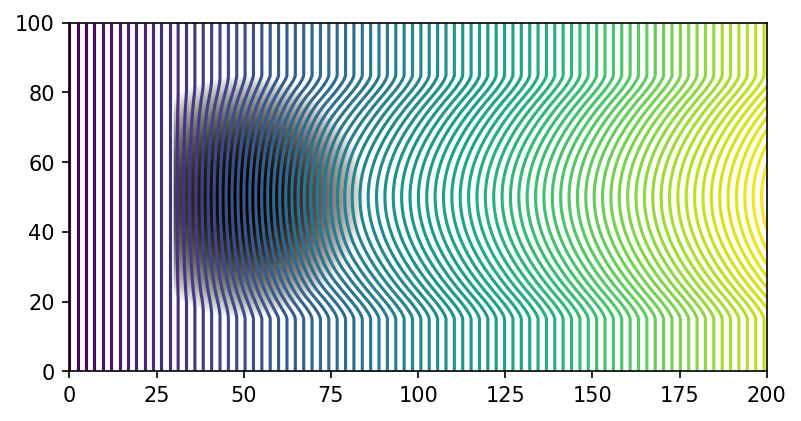

In [6]:
######################################################
# Finite-difference 3-D Traveltimes // 2D
# Qin, Fuhao, et al. "Finite-difference solution of the eikonal equation along expanding wavefronts." Geophysics 57.3 (1992): 478-487.
# https://doi.org/10.1190/1.1443263
######################################################


c = 3e8      # speed
num = 500    # grid numbers
zz, xx = np.meshgrid(np.linspace(0, 200, 2*num+1, endpoint=True), np.linspace(0, 100, num+1, endpoint=True))  
dz= np.diff(zz)[0, 0]

t = np.zeros(zz.shape)
t[:, 0] = 0
t[:, 1] = zz[:, 0]/c
# t[0, :] = zz[0]*c
# t[-1, :] = zz[0]*c

n = np.ones(zz.shape)

for j in np.arange(1, zz.shape[1]):
    for i in np.arange(0, zz.shape[0]):
        n[i, j] = system_index(zz[i, j], xx[i, j])
        t[i, j] =  t[i, j-1] + np.sqrt((dz*(n[i, j]+n[i, j-1])/2/c)**2 - 0*(t[i, j-1] - t[i-1, j])**2)  ## approximation

plt.figure(dpi=150)
plt.imshow(n, cmap='gray_r', origin='lower', extent=[zz.min(), zz.max(), xx.min(), xx.max()])
plt.contour(zz, xx, t, levels=100)
# plt.colorbar()